## Outlier in temperature und hight entfernen/ersetzen

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Wir starten mit dem Einlesen von den Datensätzen. Zusätzlich steht der Datensatz "df_weather" zur Verfügung, von dem wir stündliche Temperaturmessungen aus Frankfurt a. M. für 2020-2021 zur Verfügung gestellt bekommen.  <br>
Quelle: https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivstunden.html;jsessionid=14CD53D92EDD3C348831CA6685EE77B1.live31094?nn=16102 <br>
(Ich hab den in Excel schonmal formatiert, sieht deshalb anders aus wenn man ihn von der Seite runterläd)

In [2]:
df_garbage = pd.read_csv("cleaned_data.csv")
df_weather = pd.read_csv("weather_data.csv", sep=";")

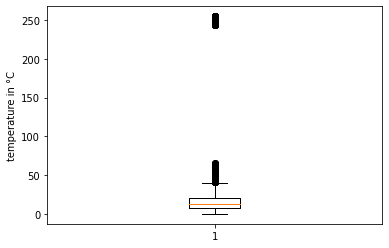

In [3]:
# Visualize the Temperature Outlier
plt.boxplot(df_garbage["decoded_data.sensor_data.Temperature"])
plt.ylabel("temperature in °C")
plt.show()

In [4]:
# look up the date format at both datasets
df_weather.head(1)

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,1420,2020011700,3,2.3,99.0,eor


In [5]:
df_garbage.head(1)

,id,deveui,created_at,decoded_data.sensor_data.Events,decoded_data.sensor_data.Height 1,decoded_data.sensor_data.Temperature,decoded_data.sensor_data.Tilt,decoded_data.sensor_data.Tx Event
0,4110576,70B3D500700016DA,2021-05-08 20:26:00.596017,SENS_EVENT_MEASURE,112,14,1,193


### Wir wollen das Datum in beiden Datensätzen gleich haben. <br> Dafür müssen diese u. A. in einem datetime Datentyp von Pandas umgewandelt und entsprechend angepasst werden.

In [6]:
# Create copy of the original weather_data
weather = df_weather.copy()

In [7]:
# Change date format
weather["MESS_DATUM"] = pd.to_datetime(weather["MESS_DATUM"], format="%Y%m%d%H")
print("old format: ", df_weather["MESS_DATUM"][1],"\n" + "new format: ", weather["MESS_DATUM"][1])

old format:  2020011701 
new format:  2020-01-17 01:00:00


In [8]:
# Find out where to cut weather data (date period of interest: 05.2020-05.2021)
print(min(df_garbage["created_at"]))
print(max(df_garbage["created_at"]))

2020-05-09 00:17:44.786185
2021-05-08 22:25:09.253756


In [9]:
minloc = weather.loc[weather["MESS_DATUM"]== "2020-05-09"]
print(minloc)
maxloc = weather.loc[weather["MESS_DATUM"]== "2021-05-09"]
print(maxloc)

      STATIONS_ID MESS_DATUM  QN_9  TT_TU  RF_TU  eor
2712         1420 2020-05-09     3   15.9   49.0  eor
       STATIONS_ID MESS_DATUM  QN_9  TT_TU  RF_TU  eor
11472         1420 2021-05-09     1    7.5   83.0  eor


In [10]:
# truncate weather data at those indices, so we have the same period in time
weather = weather.truncate(before=2712, after=11472)

In [11]:
# reverse, because df_garbage starts in 2021 and reset the index.
weather = weather.reindex(index=weather.index[::-1])
weather = weather.reset_index(drop=True)
print(weather.head())
print(df_garbage[["created_at", "decoded_data.sensor_data.Temperature"]])

   STATIONS_ID          MESS_DATUM  QN_9  TT_TU  RF_TU  eor
0         1420 2021-05-09 00:00:00     1    7.5   83.0  eor
1         1420 2021-05-08 23:00:00     1    8.8   76.0  eor
2         1420 2021-05-08 22:00:00     1    9.8   72.0  eor
3         1420 2021-05-08 21:00:00     1   12.4   60.0  eor
4         1420 2021-05-08 20:00:00     1   13.0   56.0  eor
                        created_at  decoded_data.sensor_data.Temperature
0       2021-05-08 20:26:00.596017                                    14
1       2021-05-08 19:26:05.713448                                    17
2       2021-05-08 18:25:59.323267                                    15
3       2021-05-08 17:25:59.523137                                    19
4       2021-05-08 16:25:59.577446                                    20
...                            ...                                   ...
515032  2020-05-09 04:50:15.056761                                    19
515033  2020-05-09 03:50:15.256986                      

In [12]:
# Both dataframes look equal except for the minutes, seconds and mil. seconds.
# To adjust this problem, we can round those values to hours.

In [13]:
# convert create_at into pd_datetime
df_garbage["created_at"] = pd.to_datetime(df_garbage["created_at"])
df_garbage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515037 entries, 0 to 515036
Data columns (total 8 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   id                                    515037 non-null  int64         
 1   deveui                                515037 non-null  object        
 2   created_at                            515037 non-null  datetime64[ns]
 3   decoded_data.sensor_data.Events       515037 non-null  object        
 4   decoded_data.sensor_data.Height 1     515037 non-null  int64         
 5   decoded_data.sensor_data.Temperature  515037 non-null  int64         
 6   decoded_data.sensor_data.Tilt         515037 non-null  int64         
 7   decoded_data.sensor_data.Tx Event     515037 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 31.4+ MB


In [14]:
# cut out all temp outliers with their indices in the original data
temp_outlier = df_garbage[df_garbage["decoded_data.sensor_data.Temperature"] >=200]

In [15]:
temp_outlier.head()

,id,deveui,created_at,decoded_data.sensor_data.Events,decoded_data.sensor_data.Height 1,decoded_data.sensor_data.Temperature,decoded_data.sensor_data.Tilt,decoded_data.sensor_data.Tx Event
11,4103420,70B3D500700016DA,2021-05-08 02:26:02.102419,SENS_EVENT_MEASURE,124,255,2,175
12,4102927,70B3D500700016DA,2021-05-08 01:26:02.215926,SENS_EVENT_MEASURE,126,255,2,174
204,4003817,70B3D500700016DA,2021-04-26 06:26:50.667080,SENS_EVENT_MEASURE,50,255,2,147
377,3924261,70B3D500700016DA,2021-04-16 01:27:34.320887,SENS_EVENT_MEASURE,4,255,2,158
378,3923867,70B3D500700016DA,2021-04-16 00:27:34.430388,SENS_EVENT_MEASURE,4,255,2,157


In [16]:
# Round time values to hours
temp_outlier["created_at"] = pd.Series(temp_outlier["created_at"]).dt.round("H")

<ipython-input-16-2f4b5e34b428>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_outlier["created_at"] = pd.Series(temp_outlier["created_at"]).dt.round("H")


In [17]:
# replace outliers realistic temperature -> this can take a few minutes
for i, date in enumerate(temp_outlier["created_at"]):
    for datum, temp in zip(weather["MESS_DATUM"], weather["TT_TU"]):
        if date == datum:
            temp_outlier["decoded_data.sensor_data.Temperature"].iloc[i] = temp      

C:\Users\alexa\.virtualenvs\bda-analytics-challenge-Bk2p0L_m\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\alexa\.virtualenvs\bda-analytics-challenge-Bk2p0L_m\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [18]:
temp_outlier[["created_at","decoded_data.sensor_data.Temperature"]]

,created_at,decoded_data.sensor_data.Temperature
11,2021-05-08 02:00:00,0.3
12,2021-05-08 01:00:00,1.0
204,2021-04-26 06:00:00,5.5
377,2021-04-16 01:00:00,3.9
378,2021-04-16 00:00:00,2.2
...,...,...
504033,2020-11-29 21:00:00,-0.9
504191,2020-11-21 07:00:00,-1.0
504193,2020-11-21 05:00:00,-0.8
509310,2021-02-10 08:00:00,-9.7


In [19]:
# Check for any missing data
temp_outlier["decoded_data.sensor_data.Temperature"].isna().any()

False

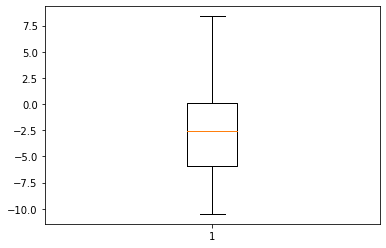

In [20]:
# Check if we have any outliers left
plt.boxplot(temp_outlier["decoded_data.sensor_data.Temperature"])
plt.show()

In [21]:
# now replace temperature outliers in original data with new temperature
df_garbage["decoded_data.sensor_data.Temperature"].update(temp_outlier["decoded_data.sensor_data.Temperature"])

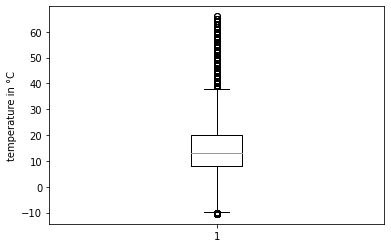

In [22]:
plt.boxplot(df_garbage["decoded_data.sensor_data.Temperature"])
plt.ylabel("temperature in °C")
plt.show()

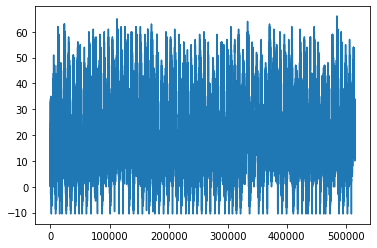

In [23]:
plt.plot(df_garbage["decoded_data.sensor_data.Temperature"])
plt.show()

## Nun gucken wir uns die Height Outlier an. <br>
Da wir noch keine Höhenangabe für die Container haben, kümmern wir uns erstmal nur um die extremen (~250cm)

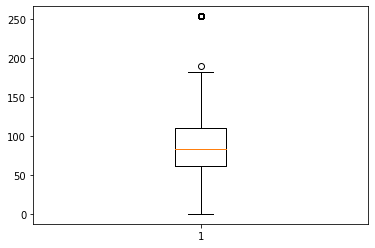

In [24]:
plt.boxplot(df_garbage["decoded_data.sensor_data.Height 1"])
plt.show()

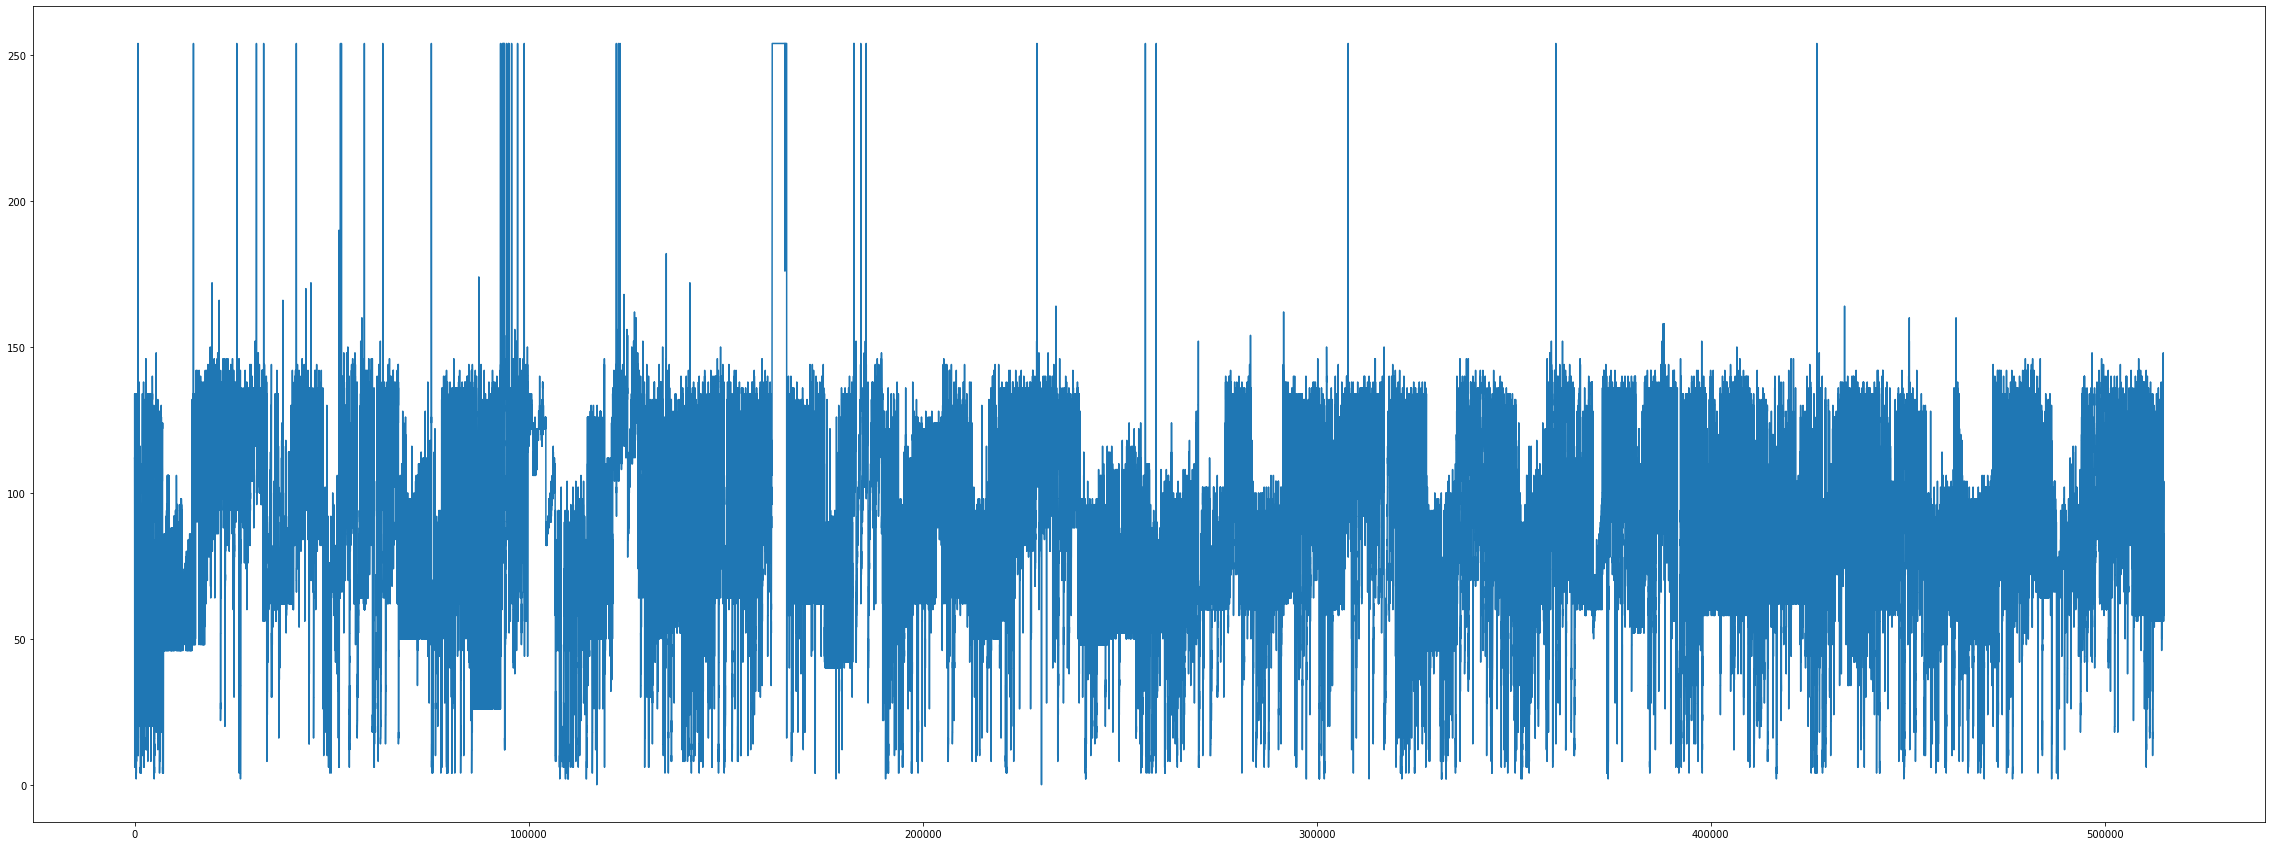

In [25]:
plt.figure(figsize=(40,15))
plt.plot(df_garbage["decoded_data.sensor_data.Height 1"])
plt.show()

In [26]:
height_outlier = df_garbage[df_garbage["decoded_data.sensor_data.Height 1"]>= 225]
print(len(height_outlier))
print(len(df_garbage["decoded_data.sensor_data.Height 1"]))

3804
515037


In [27]:
# How much of the whole dataframe is affected?
3804/515037

0.007385877131157567

### Solange wir keine näheren Informationen zu der Größe des Containers bekommen, würde ich diese Daten erstmal herausnehmen.

In [28]:
df_garbage.drop(df_garbage.loc[df_garbage["decoded_data.sensor_data.Height 1"]>=225].index, inplace=True)
df_garbage = df_garbage.reset_index(drop=True)

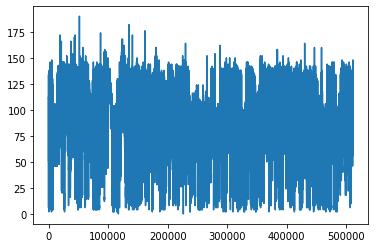

In [29]:
plt.plot(df_garbage["decoded_data.sensor_data.Height 1"])
plt.show()

In [30]:
df_garbage.head()

,id,deveui,created_at,decoded_data.sensor_data.Events,decoded_data.sensor_data.Height 1,decoded_data.sensor_data.Temperature,decoded_data.sensor_data.Tilt,decoded_data.sensor_data.Tx Event
0,4110576,70B3D500700016DA,2021-05-08 20:26:00.596017,SENS_EVENT_MEASURE,112,14.0,1,193
1,4110093,70B3D500700016DA,2021-05-08 19:26:05.713448,SENS_EVENT_MEASURE,112,17.0,1,192
2,4109607,70B3D500700016DA,2021-05-08 18:25:59.323267,SENS_EVENT_MEASURE,108,15.0,0,191
3,4109118,70B3D500700016DA,2021-05-08 17:25:59.523137,SENS_EVENT_MEASURE,126,19.0,1,190
4,4108627,70B3D500700016DA,2021-05-08 16:25:59.577446,SENS_EVENT_MEASURE,118,20.0,0,189


In [31]:
min(df_garbage["decoded_data.sensor_data.Height 1"][df_garbage["deveui"] == '70B3D5007000174F'])

4

##  Feature -> Leerung hat stattgefunden: 1/0 (erster Ansatz)

In [32]:
# check leerung if dataframe at t has less than 70% height of dataframe at t-1 also if deveui == devui to prevent
# incorrect data when switching container. 
height = df_garbage["decoded_data.sensor_data.Height 1"]
lst = [0]
for i in range(1,len(height)):
    if height[i] /height[i-1] <= 0.3 and df_garbage["deveui"][i] == df_garbage["deveui"][i-1]:
        lst.append(100)
    else:
        lst.append(0)

<ipython-input-32-ed1224476f23>:6: RuntimeWarning: divide by zero encountered in longlong_scalars
  if height[i] /height[i-1] <= 0.3 and df_garbage["deveui"][i] == df_garbage["deveui"][i-1]:


In [33]:
# add new feature to dataframe
leerung = pd.Series(lst)
df_garbage["Leerung(0/1)"] = leerung.values
df_garbage[["decoded_data.sensor_data.Height 1","Leerung(0/1)"]][370:375]

,decoded_data.sensor_data.Height 1,Leerung(0/1)
370,126,0
371,124,0
372,126,0
373,4,100
374,4,0


In [34]:
pd.unique(df_garbage["deveui"])

array(['70B3D500700016DA', '70B3D500700016DE', '70B3D500700016DF',
       '70B3D500700016E0', '70B3D500700016E5', '70B3D500700016E6',
       '70B3D500700016E7', '70B3D500700016EB', '70B3D500700016EE',
       '70B3D500700016F1', '70B3D500700016F2', '70B3D500700016F4',
       '70B3D500700016F6', '70B3D500700016F7', '70B3D500700016FA',
       '70B3D500700016FC', '70B3D50070001700', '70B3D50070001701',
       '70B3D50070001704', '70B3D50070001706', '70B3D50070001708',
       '70B3D50070001709', '70B3D5007000170F', '70B3D50070001710',
       '70B3D50070001712', '70B3D50070001713', '70B3D50070001714',
       '70B3D50070001715', '70B3D50070001716', '70B3D5007000171A',
       '70B3D5007000171E', '70B3D5007000171F', '70B3D50070001722',
       '70B3D50070001724', '70B3D50070001725', '70B3D50070001726',
       '70B3D50070001727', '70B3D5007000172B', '70B3D5007000172C',
       '70B3D5007000172D', '70B3D5007000172E', '70B3D50070001730',
       '70B3D50070001731', '70B3D50070001733', '70B3D500700017

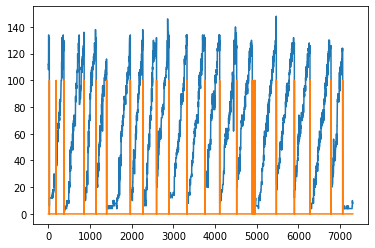

In [35]:
# look at first container
plt.plot(df_garbage[["decoded_data.sensor_data.Height 1","Leerung(0/1)"]][df_garbage["deveui"] == '70B3D500700016DA'])
plt.show()

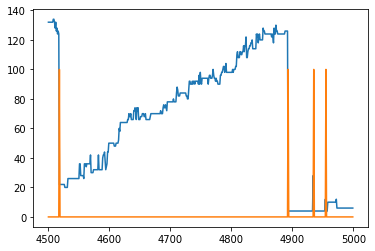

In [36]:
# take a look at the big line
plt.plot(df_garbage[["decoded_data.sensor_data.Height 1","Leerung(0/1)"]][4500:5000])
plt.show()

## Noch offene Fragen:
- Daten "glätten", damit nicht Fehler Messungen wie oben abgebildet finden?
- Was ist der beste Wert der zwischen einer Messung t und t-1 liegt, der uns sagt dass es eine leerung war?
- Wie mit den Height Outlier umgehen? -> Löschen, da es nur 0,7% der Daten ausmacht?
- Wie ist die genormte Größe von den Containern?
- Datensätze wie der untere Container, haben sehr seltsame height Daten. Erklärung? Wie damit umgehen?

Email:
- Warum haben so viele Container ein komisches Muster? (Screenshots einfügen?)
- Wenn "height" angibt wie Hoch das Glas im Container ist, wieso steigt die Höhe langsam an und fällt von einem auf den anderen Messpunkt? Das würde ja nach gegebener Definition heißen, dass der Container langsam leerer wird und auf einmal rapide voll wird? Sind die daten gespiegelt? Oder ist die Definition nicht korrekt.
- Was ist die Größe eines Containers?

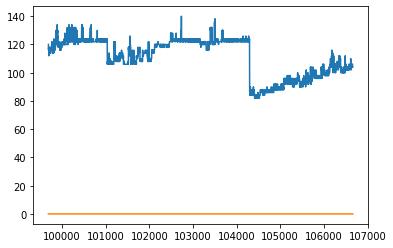

In [37]:
plt.plot(df_garbage[["decoded_data.sensor_data.Height 1","Leerung(0/1)"]][df_garbage["deveui"] == '70B3D500700016FC'])
plt.show()

In [38]:
# idee = jeden container eigenes min und max berechnen und als neues feature eintragen und daraus die
# individuellen max/min werte errechnen und somit container spezifische leerungen herausfinden

min_height = []
max_height = []
for container in pd.unique(df_garbage["deveui"]):
    min_height.append(min(df_garbage["decoded_data.sensor_data.Height 1"][df_garbage["deveui"] == container]))
    max_height.append(min(df_garbage["decoded_data.sensor_data.Height 1"][df_garbage["deveui"] == container]))
        